<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework8/hw8_210102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time 

In [2]:
# load data and only use the 'train' part of it
load = tf.keras.datasets.fashion_mnist.load_data()
print("train images",load[0][0].shape)
print("train labels",load[0][1].shape)
print("test images",load[1][0].shape)
print("test labels",load[1][1].shape)

train images (60000, 28, 28)
train labels (60000,)
test images (10000, 28, 28)
test labels (10000,)


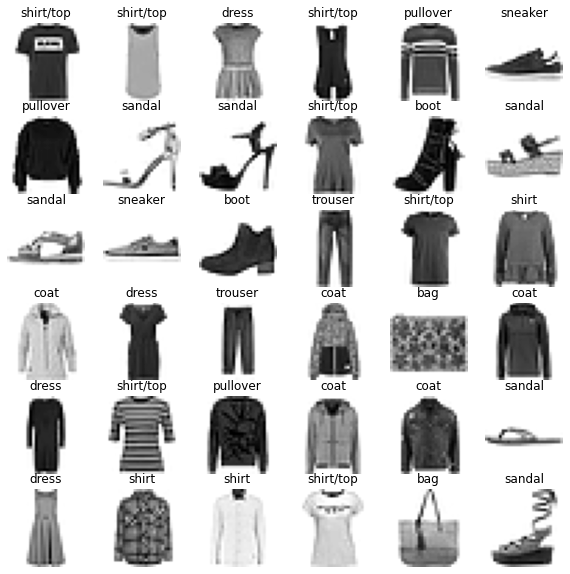

In [3]:
# plot the first entries to get an idea of the data
fig = plt.figure(figsize=(10,10))
class_names={0:'shirt/top',1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker',8:'bag', 9:'boot'}
for i in range(1,37):
  img = load[0][0][i]
  fig.add_subplot(6,6,i)
  
  plt.imshow(img, cmap="gray_r")
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title( str(class_names[int(load[0][1][i])]))

fig.show()

In [4]:
def preprocess_img(image):
  """
  normalize between 0 and 1
  """
  max = tf.math.reduce_max(image)
  min = tf.math.reduce_min(image)
  image = (image - min) / (max - min)
  image = tf.reshape(image,image.shape + (1,))
  return image

In [5]:
# Train dataset
ds_train_img = tf.data.Dataset.from_tensor_slices(load[0][0])
ds_train_img = ds_train_img.map(lambda img: preprocess_img(img))
ds_train_label = tf.data.Dataset.from_tensor_slices(load[0][1])
for entry in ds_train_label:
  print(entry)
  break;
#ds_train_label = ds_train_label.map(lambda label: tf.one_hot(label, 10))
ds_train_label = ds_train_label.map(lambda label: (1,))
for entry in ds_train_label:
  print(entry)
  break;
ds_train = tf.data.Dataset.zip((ds_train_img, ds_train_label))
#ds_train = ds_train.batch(64).shuffle(buffer_size=64)

# test dataset
"""
ds_tst_img = tf.data.Dataset.from_tensor_slices(load[1][0])
ds_tst_img = ds_tst_img.map(lambda img: preprocess_img(img))
ds_tst_label = tf.data.Dataset.from_tensor_slices(load[1][1])
ds_tst_label = ds_tst_label.map(lambda label: tf.one_hot(label, 10))
ds_tst = tf.data.Dataset.zip((ds_tst_img, ds_tst_label))
#ds_tst = ds_tst.batch(64).shuffle(buffer_size=64)
"""
print(ds_train)
#print(ds_tst)

tf.Tensor(9, shape=(), dtype=uint8)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>,)
<ZipDataset shapes: ((28, 28, 1), ((),)), types: (tf.float32, (tf.int32,))>


In [6]:
for entry in ds_train:
  print(entry[1])
  break;

(<tf.Tensor: shape=(), dtype=int32, numpy=1>,)


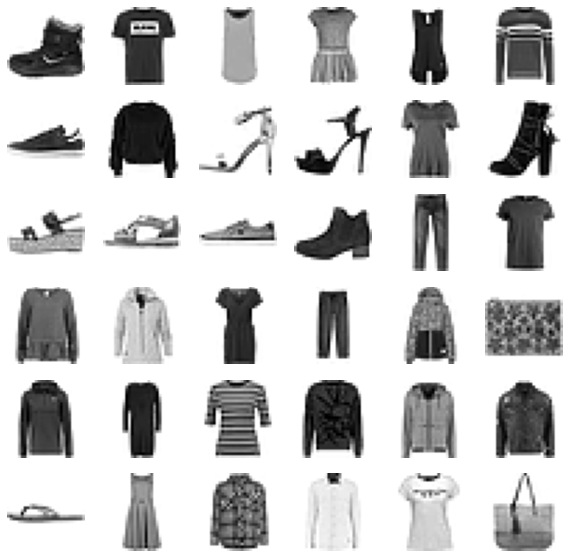

In [7]:
# re-plot the first nine entries after the mapping
def one_hot_to_int(one_hot):
  """
  reverse one hot function returning the int to the one hot vector
  """
  count = 0
  for entry in one_hot:
    if entry:
      break
    count += 1
  return count

count = 0
fig = plt.figure(figsize=(10,10))
#class_names={0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse',8:'ship', 9:'truck'}
for img in ds_train:
  count += 1
  fig.add_subplot(6,6,count)
  #print(img[0].numpy()[:,:,0])
  plt.imshow(img[0][:,:,0], cmap="gray_r")
  plt.axis('off')
  #plt.title(class_names[one_hot_to_int(img[1])])
  
  if count == 36:
    break;
fig.show()

In [8]:
# perf batching, shuffeling and prefetching
train_ds = ds_train.batch(32).shuffle(buffer_size=64).prefetch(4)
#test_ds = ds_tst.batch(64).shuffle(buffer_size=64).prefetch(4)

In [9]:
# to check the shape (here: 32 batch size and a 32x32 image with 3 colours)
for (img,label) in train_ds:
    print("image",img.shape)
    #print("label",label.shape)
    break;

image (32, 28, 28, 1)


In [28]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers

class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer_list = [
      # 28x28x1
      layers.Conv2D(16, kernel_size = 3, activation = None, padding ='same', input_shape=(28,28,1)),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPool2D(pool_size=(2,2)),
      # 14x14xN
      layers.Conv2D(32, kernel_size = 3, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.MaxPool2D(pool_size=(2,2)),
      # 7x7xN 
      
      #layers.Conv2D(64, kernel_size = 3, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      #layers.Activation('relu'),
      #layers.MaxPool2D(pool_size=(2,2)),
      # 4x4xN
      #layers.Conv2D(64, kernel_size = 3, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      #layers.Activation('relu'),
      #layers.MaxPool2D(pool_size=(2,2)),
      # 2x2xN 
      #layers.Conv2D(64, kernel_size = 3, strides=2, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      #layers.Activation('relu'),
      # 1x1xN
      
      layers.GlobalAveragePooling2D(),
      # N
      layers.Dense(1, activation="sigmoid")
    ]

  def call(self, x):
      for layer in self.layer_list:
        x = layer(x)
      return x

class Generator(Model):
  def __init__(self, space_size):
    super(Generator, self).__init__()
    #print("Embedding size:", shape)
    self.layer_list = [
      layers.Dense(49, activation="sigmoid", input_shape=((space_size,))),
      layers.Reshape((7,7,1)),
      layers.Conv2D(32, 3, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Conv2DTranspose(64,3,strides=2,activation=None,padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Conv2D(32, 3, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Conv2DTranspose(64,3,strides=2,activation=None,padding='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Conv2D(32, 3, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Conv2D(1,kernel_size=1,activation="sigmoid",padding="same")

    ]
  def call(self, x):
      for layer in self.layer_list:
        x = layer(x)
      return x


In [11]:
x = tf.ones((32,28,28,1))
print(x.shape)
disc = Discriminator()
y = disc(x)
print(y.shape)
gen = Generator(100)
rng = (tf.random.normal((32,100)))
print(rng.shape)
z = gen(rng)
print(z.shape)
#z[0,:,:,0]
#plt.imshow(z[0,:,:,0])
#print(y)


(32, 28, 28, 1)
(32, 1)
(32, 100)
(32, 28, 28, 1)


In [29]:
def random_input(batches, space_size):
  return tf.random.normal((batches, space_size))

def train_generator(generator, discriminator, space_size, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    generated_images = generator(random_input(32,space_size))
    result = discriminator(generated_images)
    loss = 1-loss_function(tf.zeros((32,1)), result)
    gradients = tape.gradient(loss, generator.trainable_variables)
  optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
  best_image = generated_images[tf.argmax(result)[0],:,:,0]
  return loss,  best_image

def train_discriminator(generator, discriminator, space_size, input, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    generated_images = generator(random_input(32,space_size))
    images = tf.concat([generated_images,input],0)
    generated_batch_size = generated_images.shape[0]
    input_batch_size = input.shape[0]
    labels = tf.concat([tf.zeros((generated_batch_size,1)),tf.ones((input_batch_size,1))],0)
    result = discriminator(images)
    #print(labels, result)
    loss = loss_function(labels, result)
    gradients = tape.gradient(loss, discriminator.trainable_variables)
  optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
  return loss, result
  
def train_step(generator, discriminator, space_size, input, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes  
  with tf.GradientTape(persistent=True) as tape:
    generated_images = generator(random_input(32,space_size))
    #images = tf.concat([generated_images,input],0)
    generated_batch_size = generated_images.shape[0]
    input_batch_size = input.shape[0]
    #labels = tf.concat([tf.zeros((generated_batch_size,1)),tf.ones((input_batch_size,1))],0)
    result_fake = discriminator(generated_images)
    result_real = discriminator(input)
    #print(labels, result)
    loss_gen = loss_function(tf.ones_like(result_fake), result_fake)
    loss_disc = loss_function(tf.ones((input_batch_size),1),result_real) + loss_function(tf.zeros((generated_batch_size,1)),result_fake)

  gradients_gen = tape.gradient(loss_gen, generator.trainable_variables)

  gradients_disc = tape.gradient(loss_disc, discriminator.trainable_variables)
  optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
  optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
  best_image = generated_images[tf.argmax(result_fake)[0],:,:,0]
  return loss_gen, loss_disc, best_image

In [26]:
#train_step()
space_size = 100
generator = Generator(space_size)
discriminator = Discriminator()

# Using binary correntropy due to values between 0 and 1
loss_function = tf.keras.losses.BinaryCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
input = tf.ones((32,28,28,1))
# loss_object and optimizer_object are instances of respective tensorflow classes  
with tf.GradientTape(persistent=True) as tape:
  generated_images = generator(random_input(32,space_size))
  #images = tf.concat([generated_images,input],0)
  generated_batch_size = generated_images.shape[0]
  input_batch_size = input.shape[0]
  #labels = tf.concat([tf.zeros((generated_batch_size,1)),tf.ones((input_batch_size,1))],0)
  result_fake = discriminator(generated_images)
  result_real = discriminator(input)
  #print(labels, result)
  loss_gen = loss_function(tf.ones_like(result_fake), result_fake)
  loss_disc = loss_function(tf.ones((input_batch_size),1),result_real) + loss_function(tf.zeros((generated_batch_size,1)),result_fake)

gradients_gen = tape.gradient(loss_gen, generator.trainable_variables)

gradients_disc = tape.gradient(loss_disc, discriminator.trainable_variables)
optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
best_image = generated_images[tf.argmax(result_fake)[0],:,:,0]
#return loss_gen, loss_disc, best_image

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  160       
_________________________________________________________________
batch_normalization_5 (Batch multiple                  64        
_________________________________________________________________
activation_5 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  4640      
_________________________________________________________________
batch_normalization_6 (Batch multiple                  128       
_________________________________________________________________
activation_6 (Activation)    multiple                

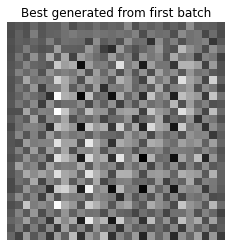

train_loss_gen: 6.212 train_loss_disc: 0.0057 running: 81.7 sec ETA: 12.3 min
Epoch: __ 1


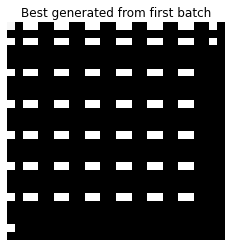

train_loss_gen: 8.2379 train_loss_disc: 0.0004 running: 164.0 sec ETA: 10.9 min
Epoch: __ 2


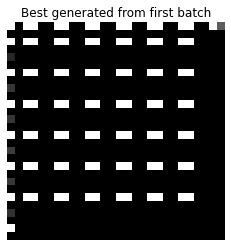

train_loss_gen: 7.3901 train_loss_disc: 0.0329 running: 247.8 sec ETA: 9.6 min
Epoch: __ 3


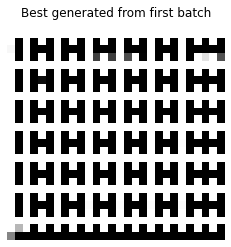

train_loss_gen: 7.3229 train_loss_disc: 0.001 running: 331.9 sec ETA: 8.3 min
Epoch: __ 4


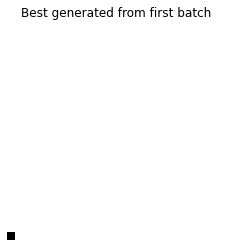

train_loss_gen: 8.9743 train_loss_disc: 0.0002 running: 416.9 sec ETA: 6.9 min
Epoch: __ 5


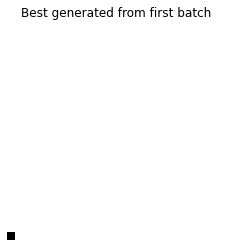

train_loss_gen: 10.2597 train_loss_disc: 0.0 running: 502.1 sec ETA: 5.6 min
Epoch: __ 6


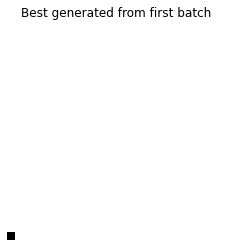

train_loss_gen: 11.3045 train_loss_disc: 0.0 running: 587.3 sec ETA: 4.2 min
Epoch: __ 7


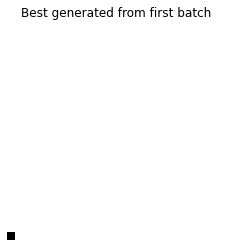

train_loss_gen: 12.2243 train_loss_disc: 0.0 running: 672.5 sec ETA: 2.8 min
Epoch: __ 8


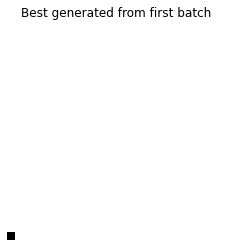

train_loss_gen: 12.8015 train_loss_disc: 0.0 running: 758.1 sec ETA: 1.4 min
Epoch: __ 9


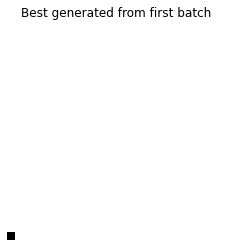

train_loss_gen: 13.8458 train_loss_disc: 0.0 running: 841.0 sec ETA: 0.0 min


In [30]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
#model = DenseNet(growth_rate=4, bottleneck=False)
#model = ResNet()
space_size = 100
generator = Generator(space_size)
discriminator = Discriminator()

# Using binary correntropy due to values between 0 and 1
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses_gen = []
train_losses_disc = []
#test_losses = []
#test_accuracies = []

#testing once before we begin
#test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)
for data in train_ds:
  discriminator(data[0])
  break
print(discriminator.summary())
generator(random_input(32,space_size))
print(generator.summary())
#print("Pre-learning")
#print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6))

#check how model performs on train data once before we begin
#train_loss, _ = test(model, train_ds, cross_entropy_loss)
#train_losses.append(train_loss)

# We train for num_epochs epochs.
time0 = time.time()
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    #time1 = time.time()
    train_ds = train_ds.shuffle(buffer_size=32)
    #test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average_gen = 0
    running_average_disc = 0
    first=True
    for (input,_) in train_ds:
        #print(input.shape)
        #break
        #train_loss_gen, output_gen = train_generator(generator, discriminator, space_size, cross_entropy_loss, optimizer)
        #train_loss_disc, output = train_discriminator(generator,discriminator, space_size, input, cross_entropy_loss, optimizer)
        train_loss_gen, train_loss_disc, output_gen = train_step(generator,discriminator, space_size, input, cross_entropy_loss, optimizer)
        running_average_gen = running_average_factor * running_average_gen  + (1 - running_average_factor) * train_loss_gen
        running_average_disc = running_average_factor * running_average_disc  + (1 - running_average_factor) * train_loss_disc
        if first:
          fig, ax = plt.subplots()
          ax.imshow(output_gen, cmap="gray_r")
          ax.axis('off')
          plt.title('Best generated from first batch')
          plt.show()
          first=False
    train_losses_gen.append(running_average_gen)
    train_losses_disc.append(running_average_disc)
    #print(running_average_gen,running_average_disc)


    #testing
    #test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    #test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)
    run_time = time.time()-time0 
    print('train_loss_gen:', round(running_average_gen.numpy(),4), 'train_loss_disc:', round(running_average_disc.numpy(),4), "running:",round(run_time,1),"sec ETA:",round(((run_time)/(epoch+1)*num_epochs-run_time)/60,1),"min")



In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses_gen,label="generator")
line2, = plt.plot(train_losses_disc,label="discriminator")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.manifold import TSNE 
time_start = time.time()
tsne = TSNE(n_components=2)
train_sub = ds_train.batch(1000).prefetch(4)
for (img,label) in train_sub:
  embedding = autoencoder(img,just_encode=True)
  labels = label
  break
print("embedding", embedding.shape)
print("labels", labels.shape)


tsne_results = tsne.fit_transform(embedding)
tsne_results

In [ ]:
print(tsne_results.shape)
length = embedding.shape[0]
combined = np.zeros((length,3))
for i in range(length):
  label = one_hot_to_int(labels[i,:])
  x = tsne_results[i,0]
  y = tsne_results[i,1]
  combined[i] = (np.array([x,y,label]))
print(combined.shape)
#combined = np.reshape(combined,(3,-1))
#print(combined.shape)


In [ ]:
def get_colours(class_num):
  colours = []
  cols = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:gray","tab:olive","tab:cyan"]
  for num in class_num:
    colours.append(cols[int(num)])
  return colours
fig, ax = plt.subplots(1,figsize=(8,8), dpi=100)
ax.scatter(x=combined[:,0],y=combined[:,1], c=get_colours(combined[:,2]))
plt.show()

In [ ]:

fig = plt.figure(figsize=(10,10))
#class_names={0:'shirt/top',1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker',8:'bag', 9:'boot'}
for i in range(1,17):
  rnd = np.random.randint(0,length+1,size=2)
  inter = (embedding[rnd[0]] + embedding[rnd[1]])/2
  inter_img = autoencoder(np.array([inter]),just_decode=True)
  fig.add_subplot(4,4,i)
  
  plt.imshow(inter_img[0,:,:,0], cmap="gray_r")
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title("Mix {} & {}".format(class_names[one_hot_to_int(labels[rnd[0]])],class_names[one_hot_to_int(labels[rnd[1]])]))

fig.show()